In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import preprocess_dataset as ut
from scipy.interpolate import BSpline
from tfkan import DenseKAN
from tensorflow import keras
from keras_tuner import HyperModel, GridSearch, RandomSearch

In [3]:
x_train = pd.read_csv("datasets/x_train.csv").to_numpy()[:, 1:]
y_train = pd.read_csv("datasets/y_train.csv").to_numpy()[:, 1:]

ut.standardize(x_train)

x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)

my_record = x_train[0]

$$
\Phi_{l} = 
\begin{bmatrix}
\phi_{11} & \phi_{12} & \cdots & \phi_{1n} \\
\phi_{21} & \phi_{22} & \cdots & \phi_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
\phi_{m1} & \phi_{m2} & \cdots & \phi_{mn}
\end{bmatrix}
$$
Dove 
$$
\phi(x) = w_bb(x) + w_s\sum_i{c_iB_i(x)}
$$

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 10.8482 - mse: 10.8482
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8511 - mse: 1.8511
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2625 - mse: 1.2625
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0860 - mse: 1.0860
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8581 - mse: 0.8581
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7449 - mse: 0.7449
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7155 - mse: 0.7155
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6924 - mse: 0.6924
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6516 - mse: 0.6516
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6191 - mse: 0.6191


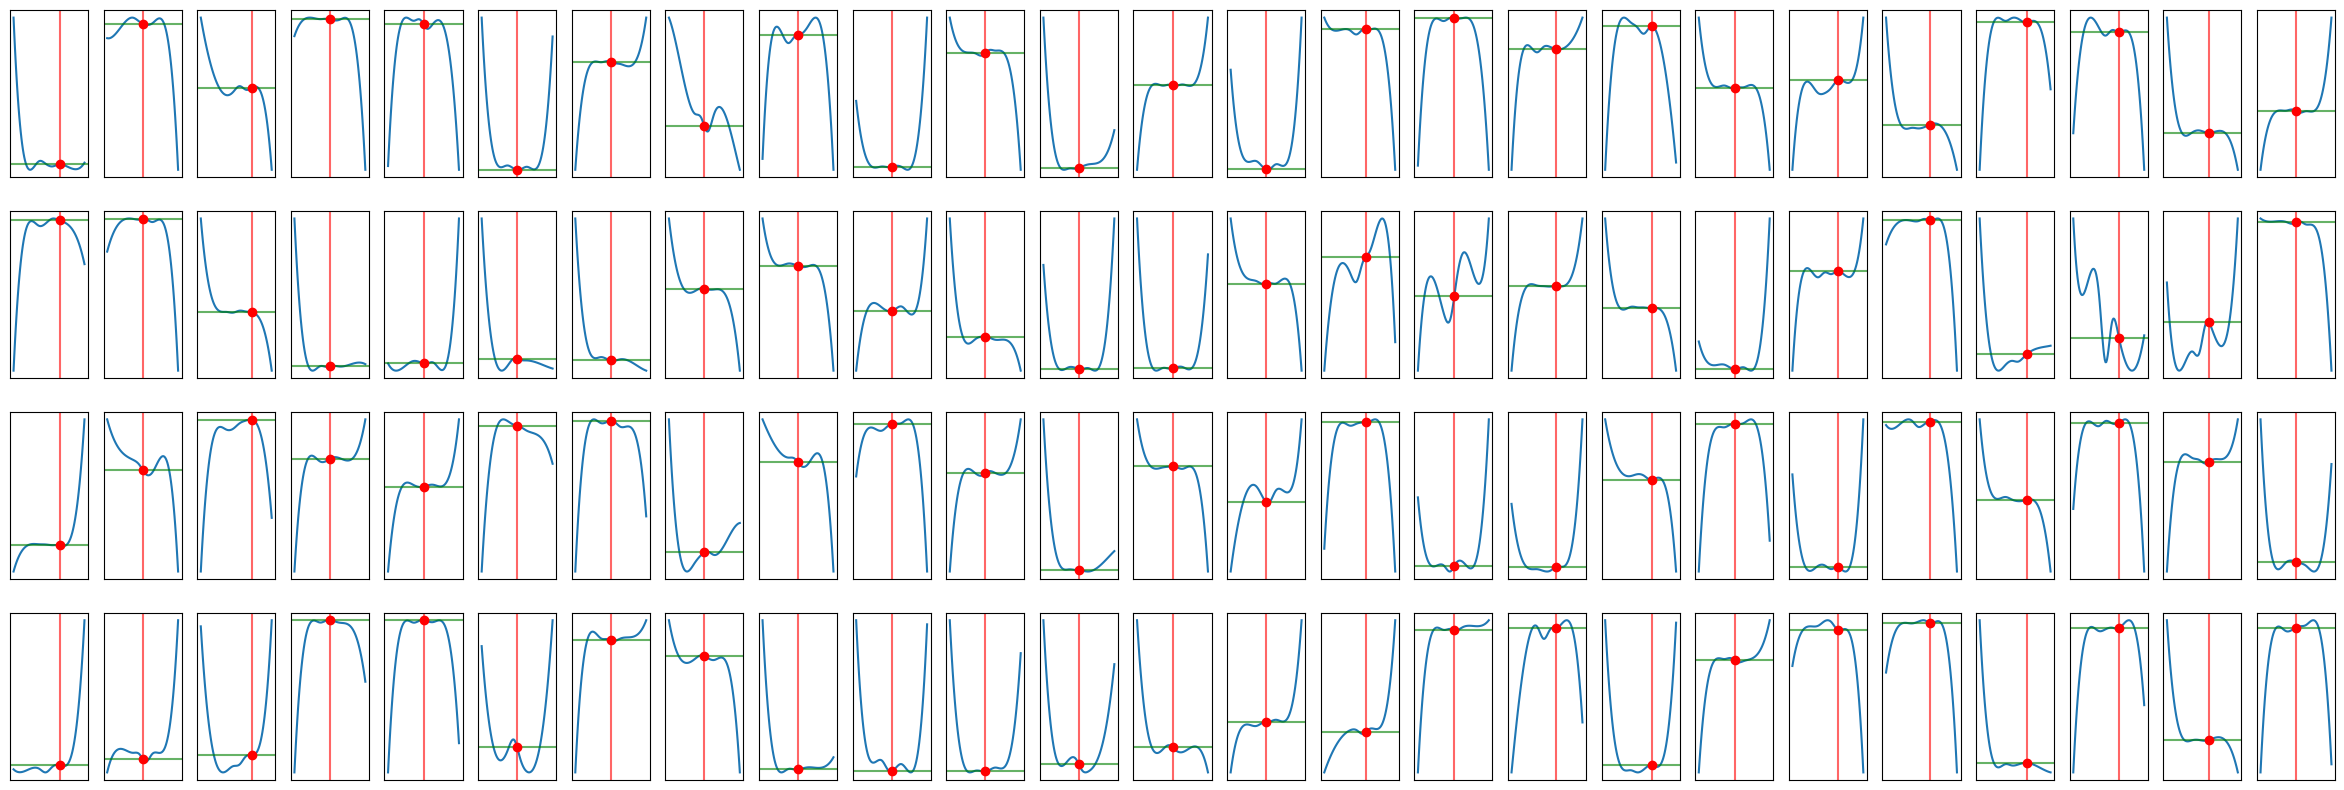

In [11]:
input_dim = x_train.shape[1]
layer1_dim = 4

# Architettura del modello
model = tf.keras.models.Sequential([
    DenseKAN(layer1_dim),
    DenseKAN(1)
])

# Compilazione del modello
model.build(input_shape=(None, input_dim))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(x_train, y_train, epochs=10, batch_size=128)

# Configurazione dell'area grafica
nrows = int(model.layers[0].units)
ncols = int(model.layers[0].input_dim)

fig, axes = plt.subplots(nrows, ncols, figsize=(30, 10))
axes = axes.flatten()

# Spline e parametri
spline_list = model.layers[0].spline_list
num_splines = len(spline_list)

w_s = np.array(model.layers[0].scale_factor)
b_act = np.array(model.layers[0].basis_activation(my_record))
b_act = [b_act] * nrows

layer1_matrix = np.zeros(nrows * ncols)

for i, spline in enumerate(spline_list):
    xx = np.linspace(spline.t[0], spline.t[-1], 100)
    yy = spline(xx)
    axes[i].plot(xx, yy)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].axvline(x=my_record[i%input_dim], color='red', alpha=0.6)
    axes[i].axhline(y=spline(my_record[i%input_dim]), color='green', alpha=0.6)
    axes[i].plot(my_record[i%input_dim], spline(my_record[i%input_dim]), 'ro')
    layer1_matrix[i] = spline(my_record[i%input_dim])

layer1_matrix = np.reshape(layer1_matrix, (nrows, ncols))
layer1_matrix = layer1_matrix * w_s.T # Formula del paper (senza bias perché i coefficienti sono inizializzati a 0)
plt.show()

$$
KAN(x) = \sum_{i_{2}=1}^{1}{\phi_{2}(\sum_{i_{1}=1}^{5}{\phi_{1}(\sum_{i_{0}=1}^{26}{\phi_{0}(x_{i_0})})})}
$$

[[-0.0807233  -0.02221332 -0.00912677  0.07495176]]


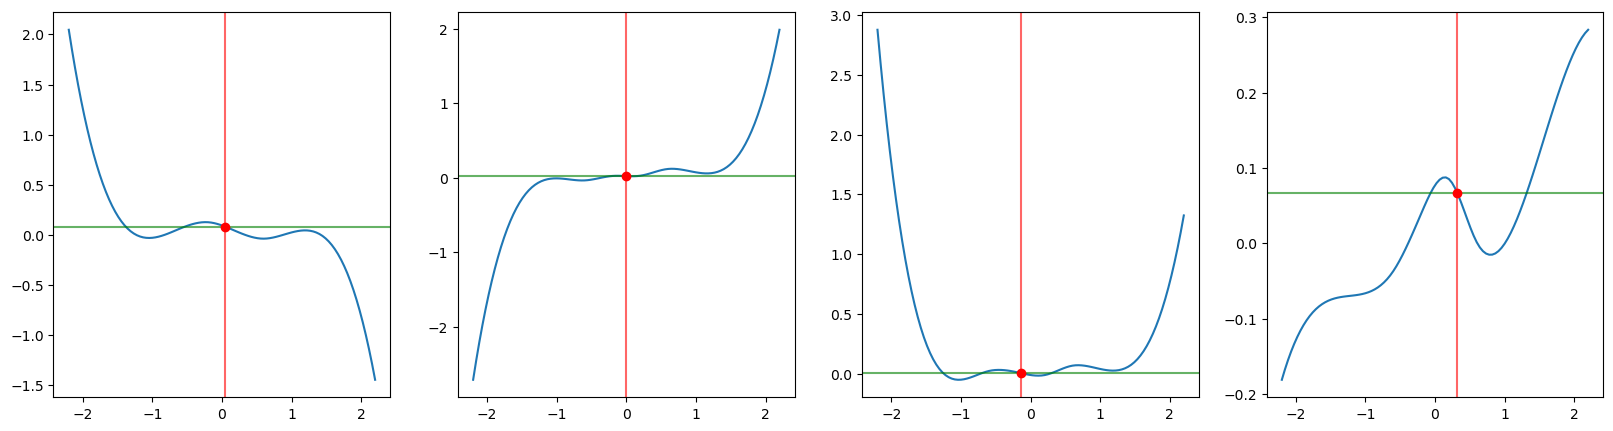

In [8]:
spline_list = model.layers[1].spline_list
num_splines = len(spline_list)

# Configurazione dell'area grafica
nrows = int(model.layers[1].units)
ncols = int(model.layers[1].input_dim)

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 5))
axes = axes.flatten()

w_s_2 = np.array(model.layers[1].scale_factor)
b_act_input = []

layer2_matrix = np.zeros(layer1_dim)

for i, spline in enumerate(spline_list):
    xx = np.linspace(spline.t[0], spline.t[-1], 100)
    yy = spline(xx)
    axes[i].plot(xx, yy)
    axes[i].axvline(x=sum(layer1_matrix[i]), color='red', alpha=0.6)
    axes[i].axhline(y=spline(sum(layer1_matrix[i])), color='green', alpha=0.6)
    axes[i].plot(sum(layer1_matrix[i]), spline(sum(layer1_matrix[i])), 'ro')
    layer2_matrix[i] = spline(sum(layer1_matrix[i]))
    b_act_input.append(sum(layer1_matrix[i]))

b_act = np.array(model.layers[1].basis_activation(b_act_input))

layer2_matrix = layer2_matrix * w_s_2.T
plt.show()

In [9]:
final_result = sum(layer2_matrix[0])
print(f"Output della rete: {final_result}")

Output della rete: -0.037111624253373596
